In [1]:
import sys
sys.path.append("..")

import core.TransformerAnalysis as TransformerAnalysis
from core.BaseModel import BaseModel
from core.DataLoader import DataPreprocessor
import core.KFoldingEvaluation as KFold
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
MAX_JETS = 4
PLOTS_DIR = f"plots/"
import os
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

DataProcessor = DataPreprocessor(
    jet_features=[
        "ordered_jet_pt",
        "ordered_jet_e",
        "ordered_jet_phi",
        "ordered_jet_eta",
        "ordered_jet_b_tag",
        "m_l1j",
        "m_l2j",
        "dR_l1j",
        "dR_l2j",
    ],
    lepton_features=["lep_pt", "lep_e", "lep_eta", "lep_phi"],
    jet_truth_label="ordered_event_jet_truth_idx",
    lepton_truth_label="event_lepton_truth_idx",
    global_features=["met_met_NOSYS", "met_phi_NOSYS"],
    max_leptons=2,
    max_jets=MAX_JETS,
    non_training_features=["truth_ttbar_pt", "truth_ttbar_mass", "N_jets", "truth_initial_parton_num_gluons", "dR_l1l2"],
    event_weight="weight_mc_NOSYS",
)

DataProcessor.load_data("/data/dust/group/atlas/ttreco/output_mc20_dilep_nuflows_partons_training.root", "reco", cut_neg_weights=False)
DataProcessor.prepare_data()
num_gluons = DataProcessor.get_feature_data("non_training", "truth_initial_parton_num_gluons").copy()
ttbar_mass = DataProcessor.get_feature_data("non_training", "truth_ttbar_mass").copy()
ttbar_pt = DataProcessor.get_feature_data("non_training", "truth_ttbar_pt").copy()
N_jets = DataProcessor.get_feature_data("non_training", "N_jets").copy()
dR_l1l2 = DataProcessor.get_feature_data("non_training", "dR_l1l2").copy()
event_weights = DataProcessor.get_feature_data("event_weight", "weight_mc_NOSYS").copy()
jet_b_tag = DataProcessor.get_feature_data("jet", "ordered_jet_b_tag").copy()
jet_pt = DataProcessor.get_feature_data("jet", "ordered_jet_pt").copy()
jet_dR = np.stack([
    DataProcessor.get_feature_data("jet", "dR_l1j").copy(),
    DataProcessor.get_feature_data("jet", "dR_l2j").copy(),
], axis=-1)
mass_lj = np.stack([
    DataProcessor.get_feature_data("jet", "m_l1j").copy(),
    DataProcessor.get_feature_data("jet", "m_l2j").copy(),
], axis=-1)
labels = DataProcessor.get_labels().copy()
truth_idx = labels.argmax(axis = -2)
DataProcessor.normalise_data()



2025-07-11 10:20:26.356561: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 10:20:26.360169: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 10:20:26.371179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752222026.389472   17802 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752222026.395053   17802 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752222026.409146   17802 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
def dR_jet_matcher(jet_b_tag, jet_dR, jet_pt):
    jet_matcher_indices = np.empty((jet_b_tag.shape[0], 2), dtype = int)
    for i in range(len(jet_b_tag)):
        valid_indices = np.where(jet_b_tag[i] != -999)[0]
        b_tag_indices = []
        if len(valid_indices) < 2:
            continue
        if np.sum(jet_b_tag[i, valid_indices] > 2) >= 2:
            b_tag_indices = valid_indices[np.where(jet_b_tag[i, valid_indices] > 2)[0]]
        elif np.sum(jet_b_tag[i, valid_indices] > 2) == 1:
            b_tag_indices.append(valid_indices[np.argsort(jet_b_tag[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.where(jet_b_tag[i, valid_indices] <= 2)[0][0]])
        else:
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-2]])
        # Find the (jet, lepton) pair with the smallest dR
        dR_sub = jet_dR[i, valid_indices, :]
        jet_idx, lep_idx = np.unravel_index(np.argmin(dR_sub), dR_sub.shape)
        first_jet = valid_indices[jet_idx]
        jet_matcher_indices[i][lep_idx] = first_jet

        # Remove the assigned jet from valid_indices and assign the remaining lepton to the next best jet
        remaining_lep = 1 - lep_idx
        remaining_jets = np.delete(valid_indices, jet_idx)
        next_jet_idx = remaining_jets[np.argmin(jet_dR[i, remaining_jets, remaining_lep])]
        jet_matcher_indices[i][remaining_lep] = next_jet_idx
    return jet_matcher_indices

dR_jet_matcher_indices = dR_jet_matcher(jet_b_tag, jet_dR, jet_pt)
ml_jet_matcher_indices = dR_jet_matcher(jet_b_tag, mass_lj, jet_pt)


In [ ]:
dR_jet_matcher_indices, truth_idx, 

In [3]:
reload(TransformerAnalysis)
reload(KFold)

TransformerMatcher = KFold.KFoldEvaluation(TransformerAnalysis.SimpleTransformer, DataProcessor,n_folds=5, n_splits=4)
TransformerMatcher.load_model("/data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher.keras")

New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
New SimpleTransformer model initialized.
Loading model from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_0.keras


2025-07-11 10:20:32.667865: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model loaded from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_0.keras
Loading model from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_1.keras
Model loaded from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_1.keras
Loading model from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_2.keras
Model loaded from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_2.keras
Loading model from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_3.keras
Model loaded from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_3.keras
Loading model from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_4.keras
Model loaded from /data/dust/group/atlas/ttreco/plots_trans_hpo/32_2_8_1_0.05_0.001_0.5/jet_matcher_4.keras
Loading model from /data

In [ ]:
TransformerMatcher.plot_confusion_matrix()

In [ ]:
TransformerMatcher.evaluate_accuracy()

In [ ]:
fig, ax = TransformerMatcher.accuracy_vs_feature("truth_initial_parton_num_gluons","non_training",bins = 3, xlims = (0, 3))
BaseModel.plot_accuracy_feature(truth_idx, dR_jet_matcher_indices, num_gluons, fig=fig, ax=ax, feature_name="dR_jet_matcher_indices",bins = 3, xlims = (0, 3), accuracy_color= "orange", label="dR Jet Matcher")
BaseModel.plot_accuracy_feature(truth_idx, ml_jet_matcher_indices, num_gluons, fig=fig, ax=ax, feature_name="ml_jet_matcher_indices",bins = 3, xlims = (0, 3), accuracy_color= "green", label="ML Jet Matcher")
ax.set_xlabel("Initial State")
ax.set_xticks(np.arange(3) + 0.5)
ax.set_xticklabels([  r"$qq\to t\overline{t}$",  r"$qg\to t\overline{t}$", r"$gg\to t\overline{t}$"])
ax.set_ylabel("Accuracy")
ax.legend()
#ax.set_yscale("log")
#ax.set_ylim(0.2, 1.05)
#ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/accuracy_vs_initial_state.png", bbox_inches='tight')

In [ ]:
hist_2d, x, y = np.histogram2d(num_gluons, N_jets, bins=(3, 5), range=((0, 3),(2, 7)))
hist_2d = hist_2d[:, ::-1]
hist_2d = hist_2d.T
hist_2d = hist_2d / np.sum(hist_2d, axis = 0)
cumsum_hist_2d = np.cumsum(hist_2d, axis = 0)
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x[:-1], hist_2d[0,:], width=1, label=f"{int(y[-2])} jets")
for i in range(1, hist_2d.shape[0]):
    ax.bar(x[:-1],hist_2d[i, :], width=1, label=f"{int(y[-2-i])} jets", bottom=cumsum_hist_2d[i - 1,:])
ax.legend()
ax.set_xlabel("Initial state")
ax.set_ylabel("Fraction of events")
ax.set_xticks(np.arange(3))
ax.set_xticklabels([  r"$qq\to t\overline{t}$",  r"$qg\to t\overline{t}$", r"$gg\to t\overline{t}$"])
fig.savefig(f"{PLOTS_DIR}/initial_state_vs_N_jets.png", bbox_inches='tight')

In [ ]:
ttbar_mass_n_gluon_0 = ttbar_mass[num_gluons == 0]
ttbar_mass_n_gluon_1 = ttbar_mass[num_gluons == 1]
ttbar_mass_n_gluon_2 = ttbar_mass[num_gluons == 2]

hist_bins = np.linspace(340e3, 800e3, 11)

# Get counts for error calculation
counts_0, _ = np.histogram(ttbar_mass_n_gluon_0, bins=hist_bins)
counts_1, _ = np.histogram(ttbar_mass_n_gluon_1, bins=hist_bins)
counts_2, _ = np.histogram(ttbar_mass_n_gluon_2, bins=hist_bins)

# Normalize to density
bin_width = np.diff(hist_bins)
norm_0 = np.sum(counts_0 * bin_width)
norm_1 = np.sum(counts_1 * bin_width)
norm_2 = np.sum(counts_2 * bin_width)


ttbar_mass_total = counts_0 + counts_1 + counts_2

ttbar_mass_n_gluon_0_hist = counts_0 / ttbar_mass_total
ttbar_mass_n_gluon_1_hist = counts_1 / ttbar_mass_total
ttbar_mass_n_gluon_2_hist = counts_2 / ttbar_mass_total




# Statistical errors (Poisson)
err_0 = np.sqrt(counts_0) 
err_1 = np.sqrt(counts_1) 
err_2 = np.sqrt(counts_2) 

bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(bin_centers, ttbar_mass_n_gluon_1_hist, width=bin_width, label=r"$gq\to t\overline{t}$")
ax.bar(bin_centers, ttbar_mass_n_gluon_0_hist, width=bin_width, label=r"$qq\to t\overline{t}$", bottom=ttbar_mass_n_gluon_1_hist)
ax.bar(bin_centers, ttbar_mass_n_gluon_2_hist, width=bin_width, label=r"$gg\to t\overline{t}$", bottom=ttbar_mass_n_gluon_1_hist + ttbar_mass_n_gluon_0_hist)
ax.set_xlabel(r"$m(t\overline{t})$ [GeV]")
ax.set_ylabel("Proportion")
ax.set_title(r"Distribution of $m(t\overline{t})$ for different initial states")
ax.legend()
ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_pdf_initial_state.png", bbox_inches='tight')


In [ ]:
ttbar_mass_n_gluon_0_hist + ttbar_mass_n_gluon_1_hist + ttbar_mass_n_gluon_2_hist

In [ ]:
ttbar_pt_n_gluon_0 = ttbar_pt[num_gluons == 0]
ttbar_pt_n_gluon_1 = ttbar_pt[num_gluons == 1]
ttbar_pt_n_gluon_2 = ttbar_pt[num_gluons == 2]

hist_bins = np.linspace(0, 800e3, 10)
ttbar_pt_n_gluon_0_hist, _ = np.histogram(ttbar_pt_n_gluon_0, bins=hist_bins, density=True)
ttbar_pt_n_gluon_1_hist, _ = np.histogram(ttbar_pt_n_gluon_1, bins=hist_bins, density=True)
ttbar_pt_n_gluon_2_hist, _ = np.histogram(ttbar_pt_n_gluon_2, bins=hist_bins, density=True)

ttbar_pt_n_gluon_0_hist = np.cumsum(ttbar_pt_n_gluon_0_hist) * np.diff(hist_bins)
ttbar_pt_n_gluon_1_hist = np.cumsum(ttbar_pt_n_gluon_1_hist) * np.diff(hist_bins)
ttbar_pt_n_gluon_2_hist = np.cumsum(ttbar_pt_n_gluon_2_hist) * np.diff(hist_bins)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(hist_bins[:-1], ttbar_pt_n_gluon_0_hist, label=r"$qq\to t\overline{t}$", marker='o')
ax.plot(hist_bins[:-1], ttbar_pt_n_gluon_1_hist, label=r"$gq\to t\overline{t}$", marker='o')
ax.plot(hist_bins[:-1], ttbar_pt_n_gluon_2_hist, label=r"$gg\to t\overline{t}$", marker='o')
ax.set_xlabel(r"$p_T(t\overline{t})$ [GeV]")
ax.set_ylabel("Cumulative Distribution Function (CDF)")
ax.set_title(r"CDF of $p_T(t\overline{t})$ for different initial states")
ax.legend()
fig.savefig(f"{PLOTS_DIR}/ttbar_pt_cdf_initial_state.png", bbox_inches='tight')

In [ ]:
dR_l1l2_n_gluon_0 = dR_l1l2[num_gluons == 0]
dR_l1l2_n_gluon_1 = dR_l1l2[num_gluons == 1]
dR_l1l2_n_gluon_2 = dR_l1l2[num_gluons == 2]
hist_bins = np.linspace(0, 5, 11)
dR_l1l2_n_gluon_0_hist, _ = np.histogram(dR_l1l2_n_gluon_0, bins=hist_bins, density=True)
dR_l1l2_n_gluon_1_hist, _ = np.histogram(dR_l1l2_n_gluon_1, bins=hist_bins, density=True)
dR_l1l2_n_gluon_2_hist, _ = np.histogram(dR_l1l2_n_gluon_2, bins=hist_bins, density=True)
dR_l1l2_n_gluon_0_hist = np.cumsum(dR_l1l2_n_gluon_0_hist) * np.diff(hist_bins)
dR_l1l2_n_gluon_1_hist = np.cumsum(dR_l1l2_n_gluon_1_hist) * np.diff(hist_bins)
dR_l1l2_n_gluon_2_hist = np.cumsum(dR_l1l2_n_gluon_2_hist) * np.diff(hist_bins)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(hist_bins[:-1], dR_l1l2_n_gluon_0_hist, label=r"$qq\to t\overline{t}$", marker='o')
ax.plot(hist_bins[:-1], dR_l1l2_n_gluon_1_hist, label=r"$gq\to t\overline{t}$", marker='o')
ax.plot(hist_bins[:-1], dR_l1l2_n_gluon_2_hist, label=r"$gg\to t\overline{t}$", marker='o')
ax.set_xlabel(r"$dR(\ell_1, \ell_2)$")
ax.set_ylabel("Density")
ax.set_title(r"Density of $dR(\ell_1, \ell_2)$ for different initial states")
ax.legend()
fig.savefig(f"{PLOTS_DIR}/dR_l1l2_initial_state.png", bbox_inches='tight')

In [ ]:
fig, ax = TransformerMatcher.accuracy_vs_feature("truth_ttbar_pt","non_training", xlims = (0, 700e3), bins = 25)
ax.set_xlabel(r"$p_T(t\overline{t})$ [GeV]")
ax.set_ylabel("Accuracy")
fig.savefig(f"{PLOTS_DIR}/accuracy_vs_ttbar_pt.png", bbox_inches='tight')


In [ ]:
fig, ax = TransformerMatcher.accuracy_vs_feature("truth_ttbar_mass","non_training", xlims = (340e3, 800e3), bins = 20)
BaseModel.plot_accuracy_feature(truth_idx, dR_jet_matcher_indices, ttbar_mass, fig=fig, ax=ax, feature_name="dR_jet_matcher_indices", bins = 20, xlims = (340e3, 800e3), accuracy_color= "orange", label="dR Jet Matcher")
BaseModel.plot_accuracy_feature(truth_idx, ml_jet_matcher_indices, ttbar_mass, fig=fig, ax=ax, feature_name="ml_jet_matcher_indices", bins = 20, xlims = (340e3, 800e3), accuracy_color= "green", label="ML Jet Matcher")
ax.set_xlabel(r"$m(t\overline{t})$ [GeV]")
ax.set_ylabel("Accuracy")
ax.legend()
fig.savefig(f"{PLOTS_DIR}/accuracy_vs_ttbar_mass.png", bbox_inches='tight')


Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_pt computation done.
Feature: ordered_jet_e computation done.
Feature: ordered_jet_e computation done.
Feature: ordered_jet_e computation done.
Feature: ordered_jet_e computation do

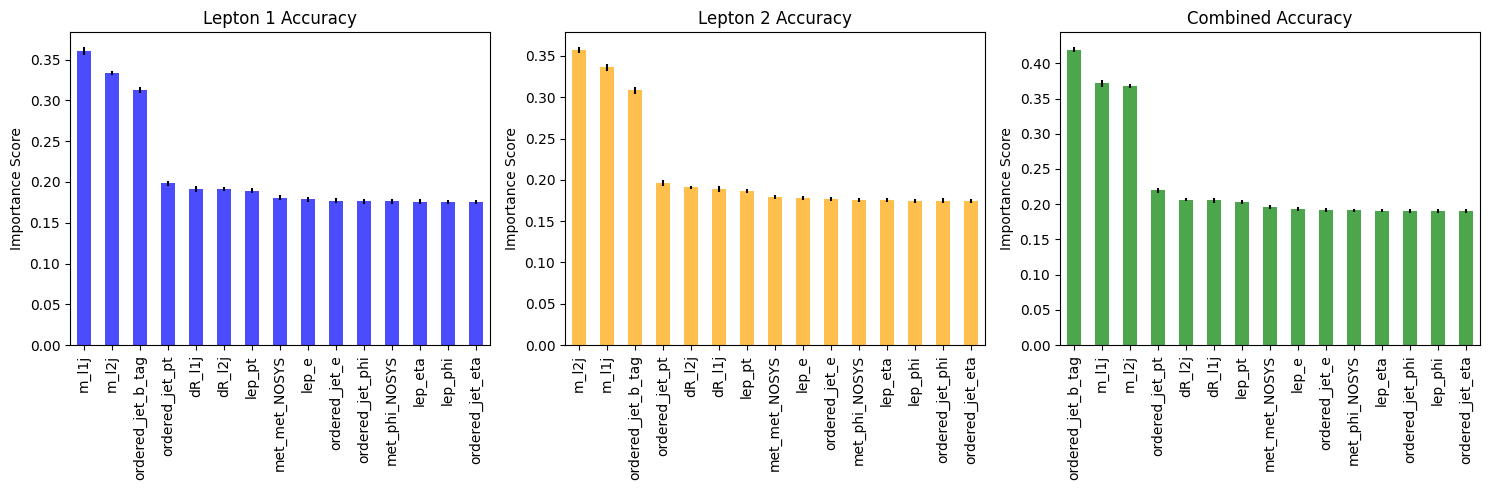

In [4]:
fig, ax = TransformerMatcher.plot_permutation_importance()
fig.savefig(f"{PLOTS_DIR}/permutation_importance.png", bbox_inches='tight')

In [ ]:
fig, ax = TransformerMatcher.plot_confusion_matrix()
fig.savefig(f"{PLOTS_DIR}/confusion_matrix.png", bbox_inches='tight')

In [ ]:
jet_match_lep_1 = np.arange(0, MAX_JETS).reshape((1,-1)) == truth_idx[:, 0].reshape((-1,1))
jet_match_lep_2 = np.arange(0, MAX_JETS).reshape((1,-1)) == truth_idx[:, 1].reshape((-1,1))
jet_mask = jet_pt != -999
b_tag_mask = jet_b_tag >= 2
dR_closest_non_matched_jet = np.zeros((jet_mask.shape[0], 2), dtype = float)
dR_lep_1_match = jet_dR[np.arange(jet_mask.shape[0]), jet_match_lep_1.argmax(axis=1), 0]
dR_lep_2_match = jet_dR[np.arange(jet_mask.shape[0]), jet_match_lep_2.argmax(axis=1), 1]

dR_closest_non_matched_jet[:, 0] = np.min(
    np.where(jet_mask & ~jet_match_lep_1, jet_dR[:, :, 0], np.inf), axis=1
) - dR_lep_1_match

dR_closest_non_matched_jet[:, 1] = np.min(
    np.where(jet_mask & ~jet_match_lep_2, jet_dR[:, :, 1] , np.inf), axis=1
) - dR_lep_2_match
fig, ax = plt.subplots(figsize=(10, 6))
bins = np.linspace(-5, 5, 20)
ax.hist(dR_closest_non_matched_jet[num_gluons == 0].flatten(), bins=bins, alpha=0.5, label=r"$qq\to t\overline{t}$ $\mu=$" + f"{np.mean(dR_closest_non_matched_jet[num_gluons == 0].flatten()):.3f}", density=True)
ax.hist(dR_closest_non_matched_jet[num_gluons == 1].flatten(), bins=bins, alpha=0.5, label=r"$qg\to t\overline{t}$ $\mu=$"  + f"{np.mean(dR_closest_non_matched_jet[num_gluons ==1].flatten()):.3f}", density=True)
ax.hist(dR_closest_non_matched_jet[num_gluons == 2].flatten(), bins=bins, alpha=0.5, label=r"$gg\to t\overline{t}$ $\mu=$"  + f"{np.mean(dR_closest_non_matched_jet[num_gluons ==2].flatten()):.3f}", density=True)

ax.set_xlabel(r"$\Delta R(\ell_{\text{no match}}, j) -\Delta R(\ell_{\text{match}}, j)$")
ax.set_ylabel("PDF")
ax.axvline(0, color='black', linestyle='--', label='Zero Line')
ax.legend()
ax.set_title("Distribution of $dR$ between closest non-matched jet and matched jet")
fig.savefig(f"{PLOTS_DIR}/dR_closest_non_matched_jet_IS.png", bbox_inches='tight')

In [ ]:
jet_match_lep_1 = np.arange(0, MAX_JETS).reshape((1,-1)) == truth_idx[:, 0].reshape((-1,1))
jet_match_lep_2 = np.arange(0, MAX_JETS).reshape((1,-1)) == truth_idx[:, 1].reshape((-1,1))
jet_mask = jet_pt != -999
b_tag_mask = jet_b_tag >= 2
dR_closest_non_matched_jet = np.zeros((jet_mask.shape[0], 2), dtype = float)
dR_lep_1_match = jet_dR[np.arange(jet_mask.shape[0]), jet_match_lep_1.argmax(axis=1), 0]
dR_lep_2_match = jet_dR[np.arange(jet_mask.shape[0]), jet_match_lep_2.argmax(axis=1), 1]

dR_closest_non_matched_jet[:, 0] = np.min(
    np.where(jet_mask & ~jet_match_lep_1 & b_tag_mask, jet_dR[:, :, 0], np.inf), axis=1
) - dR_lep_1_match

dR_closest_non_matched_jet[:, 1] = np.min(
    np.where(jet_mask & ~jet_match_lep_2 & b_tag_mask, jet_dR[:, :, 1] , np.inf), axis=1
) - dR_lep_2_match
fig, ax = plt.subplots(figsize=(10, 6))
bins = np.linspace(-5, 5, 20)
ax.hist(dR_closest_non_matched_jet[num_gluons == 0].flatten(), bins=bins, alpha=0.5, label=r"$qq\to t\overline{t}$ $\mu=$" + f"{np.mean(dR_closest_non_matched_jet[num_gluons == 0].flatten()[dR_closest_non_matched_jet[num_gluons == 0].flatten() != np.inf]):.3f}", density=True)
ax.hist(dR_closest_non_matched_jet[num_gluons == 1].flatten(), bins=bins, alpha=0.5, label=r"$qg\to t\overline{t}$ $\mu=$"  + f"{np.mean(dR_closest_non_matched_jet[num_gluons == 1].flatten()[dR_closest_non_matched_jet[num_gluons == 1].flatten() != np.inf]):.3f}", density=True)
ax.hist(dR_closest_non_matched_jet[num_gluons == 2].flatten(), bins=bins, alpha=0.5, label=r"$gg\to t\overline{t}$ $\mu=$"  + f"{np.mean(dR_closest_non_matched_jet[num_gluons == 2].flatten()[dR_closest_non_matched_jet[num_gluons == 2].flatten() != np.inf]):.3f}", density=True)

ax.set_xlabel(r"$\Delta R(\ell_{\text{no match}}, j) -\Delta R(\ell_{\text{match}}, j)$")
ax.set_ylabel("PDF")
ax.axvline(0, color='black', linestyle='--', label='Zero Line')
ax.legend()
ax.set_title("dR of closest non-matched jet with b-tagging")
fig.savefig(f"{PLOTS_DIR}/dR_closest_non_matched_jet_IS_b_tag.png", bbox_inches='tight')

In [ ]:
jet_match_lep_1 = np.arange(0, MAX_JETS).reshape((1, -1)) == truth_idx[:, 0].reshape(
    (-1, 1)
)
jet_match_lep_2 = np.arange(0, MAX_JETS).reshape((1, -1)) == truth_idx[:, 1].reshape(
    (-1, 1)
)
jet_mask = jet_pt != -999
b_tag_mask = jet_b_tag >= 2
dR_closest_non_matched_jet = np.zeros((jet_mask.shape[0], 2), dtype=float)
b_tag_dR_closest_non_matched_jet = np.zeros((jet_mask.shape[0], 2), dtype=float)
dR_lep_1_match = jet_dR[np.arange(jet_mask.shape[0]), jet_match_lep_1.argmax(axis=1), 0]
dR_lep_2_match = jet_dR[np.arange(jet_mask.shape[0]), jet_match_lep_2.argmax(axis=1), 1]

dR_closest_non_matched_jet[:, 0] = (
    np.min(np.where(jet_mask & ~jet_match_lep_1, jet_dR[:, :, 0], np.inf), axis=1)
    - dR_lep_1_match
)

dR_closest_non_matched_jet[:, 1] = (
    np.min(np.where(jet_mask & ~jet_match_lep_2, jet_dR[:, :, 1], np.inf), axis=1)
    - dR_lep_2_match
)

b_tag_dR_closest_non_matched_jet[:, 0] = (
    np.min(
        np.where(jet_mask & ~jet_match_lep_1 & b_tag_mask, jet_dR[:, :, 0], np.inf),
        axis=1,
    )
    - dR_lep_1_match
)

b_tag_dR_closest_non_matched_jet[:, 1] = (
    np.min(
        np.where(jet_mask & ~jet_match_lep_2 & b_tag_mask, jet_dR[:, :, 1], np.inf),
        axis=1,
    )
    - dR_lep_2_match
)


fig, ax = plt.subplots(figsize=(10, 6))
bins = np.linspace(-5, 5, 20)
ax.hist(
    dR_closest_non_matched_jet[dR_closest_non_matched_jet != np.inf].flatten(),
    bins=bins,
    alpha=0.5,
    density=True,
    label=r"All jets $\mu=$"
    + f"{np.mean(dR_closest_non_matched_jet[dR_closest_non_matched_jet != np.inf].flatten()):.3f}",
)
ax.hist(
    b_tag_dR_closest_non_matched_jet[
        b_tag_dR_closest_non_matched_jet != np.inf
    ].flatten(),
    bins=bins,
    alpha=0.5,
    density=True,
    label=r"b-tagged jets $\mu=$"
    + f"{np.mean(b_tag_dR_closest_non_matched_jet[b_tag_dR_closest_non_matched_jet != np.inf].flatten()):.3f}",
)
ax.set_xlabel(
    r"$\Delta R(\ell_{\text{no match}}, j) -\Delta R(\ell_{\text{match}}, j)$"
)
ax.set_ylabel("PDF")
ax.axvline(0, color="black", linestyle="--", label="Zero Line")
ax.legend()
fig.savefig(f"{PLOTS_DIR}/dR_closest_non_matched_jet_b_tag.png", bbox_inches="tight")

In [ ]:
jet_b_tag[num_gluons == 0][(~jet_match_lep_2 & jet_mask)[num_gluons == 0]]

In [ ]:
hist_2d = np.stack([
    np.histogram(jet_b_tag[num_gluons == 0][(~jet_match_lep_2 & jet_mask)[num_gluons == 0]], bins=6, range=(1, 7))[0],
    np.histogram(jet_b_tag[num_gluons == 1][(~jet_match_lep_2 & jet_mask)[num_gluons == 1]], bins=6, range=(1, 7))[0],
    np.histogram(jet_b_tag[num_gluons == 2][(~jet_match_lep_2 & jet_mask)[num_gluons == 2]], bins=6, range=(1, 7))[0],
])
x = np.linspace(0, 3,4)
y = np.arange(1, 8)

hist_2d = hist_2d[:, ::-1]
hist_2d = hist_2d.T
hist_2d = hist_2d / np.sum(hist_2d, axis = 0)
cumsum_hist_2d = np.cumsum(hist_2d, axis = 0)
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x[:-1], hist_2d[0,:], width=1, label=f"b-tag score: {int(y[-2])}")
for i in range(1, hist_2d.shape[0]):
    ax.bar(x[:-1],hist_2d[i, :], width=1, label=f"b-tag score: {int(y[-2-i])}", bottom=cumsum_hist_2d[i - 1,:])
ax.legend()
ax.set_xlabel("Initial state")
ax.set_ylabel("Fraction of events")
ax.set_xticks(np.arange(3))
ax.set_xticklabels([  r"$qq\to t\overline{t}$",  r"$qg\to t\overline{t}$", r"$gg\to t\overline{t}$"])
fig.savefig(f"{PLOTS_DIR}/initial_state_vs_N_jets.png", bbox_inches='tight')

In [ ]:
np.unique(jet_b_tag)